In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

# On Mac you may encounter an error related to OMP, this is a workaround, but slows down the code
# https://github.com/dmlc/xgboost/issues/1715
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ['CUDA_HOME'] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.3"
os.environ['CUDA_VERSION'] = "11.3"

In [2]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.9.3'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
if tf.test.gpu_device_name():
    print("Default GPU Device:{}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF if you have one.")

Default GPU Device:/device:GPU:0


In [5]:
from openbot import dataloader, data_augmentation, utils, train

Default GPU Device:/device:GPU:0


## Set train and test dirs

Define the dataset directory and give it a name. Inside the dataset folder, there should be two folders, `train_data` and `test_data`. 

In [6]:
dataset_dir = "dataset"
dataset_name = "openbot"
train_data_dir = os.path.join(dataset_dir, "train_data")
test_data_dir = os.path.join(dataset_dir, "test_data")

## Hyperparameters
<a id='hyperparameters'></a>

You may have to tune the learning rate and batch size depending on your available compute resources and dataset. As a general rule of thumb, if you increase the batch size by a factor of n, you can increase the learning rate by a factor of sqrt(n). In order to accelerate training and make it more smooth, you should increase the batch size as much as possible. In our paper we used a batch size of 128. For debugging and hyperparamter tuning, you can set the number of epochs to a small value like 10. If you want to train a model which will achieve good performance, you should set it to 50 or more. In our paper we used 100.

In [7]:
params = train.Hyperparameters()

params.MODEL = "pilot_reinforcement"  # choices: "pilot_net","cil_mobile","cil_mobile_fast","cil"
params.POLICY = "autopilot"  # choices: "autopilot","point_goal_nav"
params.TRAIN_BATCH_SIZE = 128
params.TEST_BATCH_SIZE = 16
params.LEARNING_RATE = 0.0003
params.NUM_EPOCHS = 50
params.BATCH_NORM = True  # use batch norm (recommended)
params.FLIP_AUG = False  # flip image and controls as augmentation (only autopilot)
params.CMD_AUG = False  # randomize high-level command as augmentation (only autopilot)
params.USE_LAST = False  # resume training from last checkpoint
params.WANDB = False
# policy = "autopilot": images are expected to be 256x96 - no cropping required
# policy = "point_goal_nav": images are expected to be 160x120 - cropping to 160x90
params.IS_CROP = params.POLICY == "point_goal_nav"

## Pre-process the dataset

In [8]:
tr = train.Training(params)
tr.dataset_name = dataset_name
tr.train_data_dir = train_data_dir
tr.test_data_dir = test_data_dir

Running this for the first time will take some time. This code will match image frames to the controls (labels) and indicator signals (commands).  By default, data samples where the vehicle was stationary will be removed. If this is not desired, you need to set `tr.remove_zeros = False`. If you have made any changes to the sensor files, changed `remove_zeros` or moved your dataset to a new directory, you need to set `tr.redo_matching = True`. 

In [9]:
tr.redo_matching = True
tr.remove_zeros = True
train.process_data(tr)

Train Datasets:  1
Test Datasets:  1
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
There are 5397 train images and 1716 test images
STARTING REWARD SESSION
Processing folder dataset\train_data\dataset_control\20231211_160235
 Frames and rewards matched.
BLIBLI
 Preprocessing completed.
STARTING REWARD SESSION
Processing folder dataset\train_data\dataset_control\20231211_160514
 Frames and rewards matched.
BLIBLI
 Preprocessing completed.
STARTING REWARD SESSION
Processing folder dataset\train_data\dataset_control\20231211_160937
 Frames and rewards matched.
BLIBLI
 Prepro

In [10]:
import threading


def broadcast(event, payload=None):
    print(event, payload)


event = threading.Event()
my_callback = train.MyCallback(broadcast, event)

In the next step, you can convert your dataset to a tfrecord, a data format optimized for training. You can skip this step if you already created a tfrecord before or if you want to train using the files directly. 

In [11]:
train.create_tfrecord(my_callback, policy=tr.hyperparameters.POLICY)

message Converting data to tfrecord (this may take some time)...
Reading dataset from c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\train_data
TFRecord will be saved at c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\tfrecords/train.tfrec
Number of Datasets Available:  1
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
 Preprocessing completed.
reward_file c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\train_data\dataset_control\20231211_160235\reward_data\matched_frame_reward_processed.txt
reward_file c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\train_data\dataset_control\20231211_160514\reward_data\matched_frame_reward_processed.txt
reward_file c:\Users\lilou\Documen

## Load the dataset

If you did not create a tfrecord and want to load and buffer files from disk directly, set `no_tf_record = True`.

In [12]:
no_tf_record = False

In [13]:
if no_tf_record:
    tr.train_data_dir = train_data_dir
    tr.test_data_dir = test_data_dir
    train.load_data(tr, verbose=3)
else:
    tr.train_data_dir = os.path.join(dataset_dir, "tfrecords/train.tfrec")
    tr.test_data_dir = os.path.join(dataset_dir, "tfrecords/test.tfrec")
    train.load_tfrecord(tr, verbose=0)

Image shape:  (96, 256, 3)
Command:  0.0
Label:  [0.27058825 0.27058825]
Reward:  0.0
Number of training instances:  4862
Number of test instances:  1316


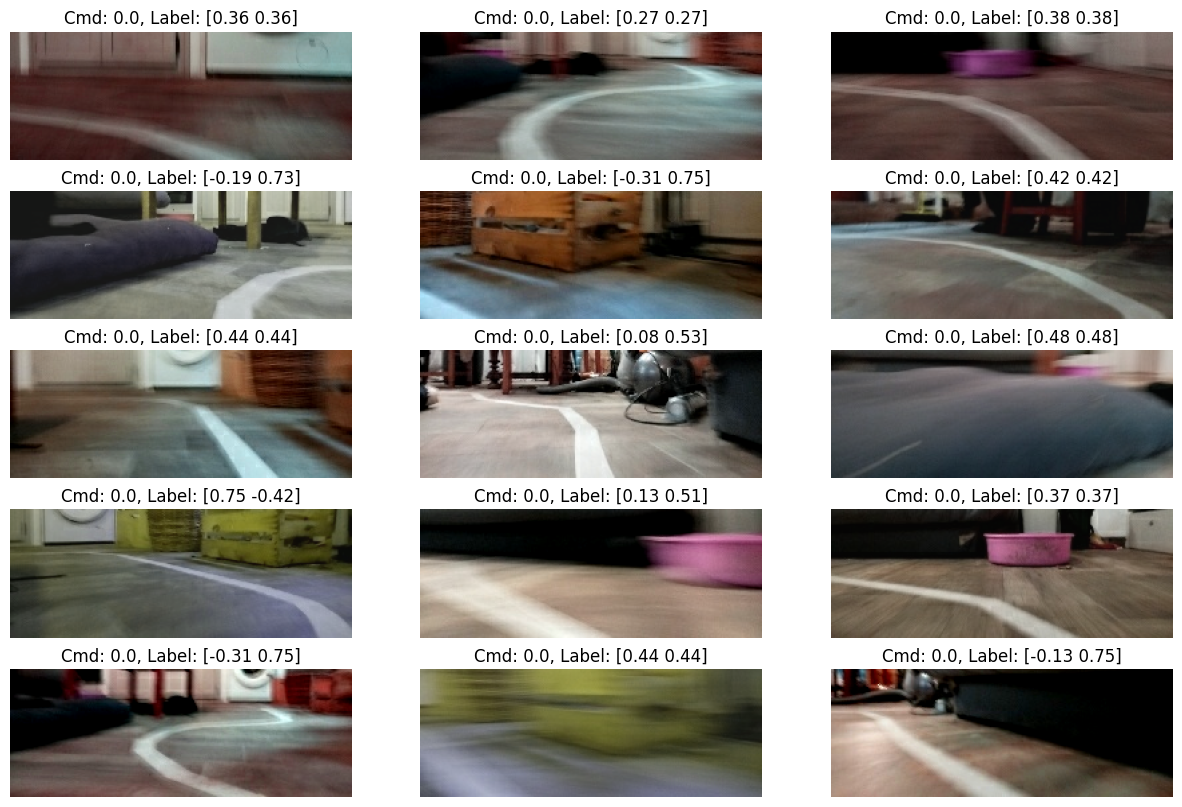

In [14]:
%matplotlib inline
utils.show_batch(dataset=tr.train_ds, policy=tr.hyperparameters.POLICY, model=None)

## Training

The number of epochs is proportional to the training time. One epoch means going through the complete dataset once. Increasing `NUM_EPOCHS` will mean longer training time, but generally leads to better performance. To get familiar with the code it can be set to small values like `5` or `10`. To train a model that performs well, it should be set to values between `50` and `200`. Setting `USE_LAST` to `true` will resume the training from the last checkpoint. The default values are `NUM_EPOCHS = 100` and `USE_LAST = False`. They are set in [Hyperparameters](#hyperparameters).

In [15]:
# params.NUM_EPOCHS = 200
# params.USE_LAST = True

train.do_training(tr, my_callback, verbose=1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
model openbot_pilot_reinforcement_lr0.0003_bz128_bn
Model: "pilot_reinforcement"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 96, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 46, 126, 24)  1824        ['img_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 46, 126, 24)  96        

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.1901933252811432, 'mean_absolute_error': 0.3204019367694855, 'direction_metric': 0.46648848056793213, 'angle_metric': 0.19243420660495758, 'val_loss': 0.09268394857645035, 'val_mean_absolute_error': 0.2608658969402313, 'val_direction_metric': 0.9977203607559204, 'val_angle_metric': 0.707446813583374, 'epoch': 0}
logs {'loss': 0.1901933252811432, 'mean_absolute_error': 0.3204019367694855, 'direction_metric': 0.46648848056793213, 'angle_metric': 0.19243420660495758, 'val_loss': 0.09268394857645035, 'val_mean_absolute_error': 0.2608658969402313, 'val_direction_metric': 0.9977203607559204, 'val_angle_metric': 0.707446813583374, 'epoch': 0}
38/38 [==============================] - 11s 180ms/step - loss: 0.1902 - mean_absolute_error: 0.3204 - direction_metric: 0.4665 - angle_metric: 0.1924 - val_loss: 0.0927 - val_mean_absolute_error: 0.2609 - val_direction_metric: 0.9977 - val_angle_metric: 0.7074
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.07294566184282303, 'mean_absolute_error': 0.2018316239118576, 'direction_metric': 0.6383634805679321, 'angle_metric': 0.31805098056793213, 'val_loss': 0.06217190623283386, 'val_mean_absolute_error': 0.18948675692081451, 'val_direction_metric': 0.43389058113098145, 'val_angle_metric': 0.20668692886829376, 'epoch': 1}
logs {'loss': 0.07294566184282303, 'mean_absolute_error': 0.2018316239118576, 'direction_metric': 0.6383634805679321, 'angle_metric': 0.31805098056793213, 'val_loss': 0.06217190623283386, 'val_mean_absolute_error': 0.18948675692081451, 'val_direction_metric': 0.43389058113098145, 'val_angle_metric': 0.20668692886829376, 'epoch': 1}
38/38 [==============================] - 6s 168ms/step - loss: 0.0729 - mean_absolute_error: 0.2018 - direction_metric: 0.6384 - angle_metric: 0.3181 - val_loss: 0.0622 - val_mean_absolute_error: 0.1895 - val_direction_metric: 0.4339 - val_angle_metric: 0.2067
Epoch 3/50
38/38 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.05958595871925354, 'mean_absolute_error': 0.1825273334980011, 'direction_metric': 0.6457648277282715, 'angle_metric': 0.32380756735801697, 'val_loss': 0.054604772478342056, 'val_mean_absolute_error': 0.16498245298862457, 'val_direction_metric': 0.5205166935920715, 'val_angle_metric': 0.27811551094055176, 'epoch': 2}
logs {'loss': 0.05958595871925354, 'mean_absolute_error': 0.1825273334980011, 'direction_metric': 0.6457648277282715, 'angle_metric': 0.32380756735801697, 'val_loss': 0.054604772478342056, 'val_mean_absolute_error': 0.16498245298862457, 'val_direction_metric': 0.5205166935920715, 'val_angle_metric': 0.27811551094055176, 'epoch': 2}
38/38 [==============================] - 6s 167ms/step - loss: 0.0596 - mean_absolute_error: 0.1825 - direction_metric: 0.6458 - angle_metric: 0.3238 - val_loss: 0.0546 - val_mean_absolute_error: 0.1650 - val_direction_metric: 0.5205 - val_angle_metric: 0.2781
Epoch 4/50
37/38 [============================>.] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.052180904895067215, 'mean_absolute_error': 0.17027750611305237, 'direction_metric': 0.6465871930122375, 'angle_metric': 0.32586348056793213, 'val_loss': 0.053696125745773315, 'val_mean_absolute_error': 0.1616290658712387, 'val_direction_metric': 0.4772036373615265, 'val_angle_metric': 0.2416413426399231, 'epoch': 3}
logs {'loss': 0.052180904895067215, 'mean_absolute_error': 0.17027750611305237, 'direction_metric': 0.6465871930122375, 'angle_metric': 0.32586348056793213, 'val_loss': 0.053696125745773315, 'val_mean_absolute_error': 0.1616290658712387, 'val_direction_metric': 0.4772036373615265, 'val_angle_metric': 0.2416413426399231, 'epoch': 3}
38/38 [==============================] - 6s 166ms/step - loss: 0.0522 - mean_absolute_error: 0.1703 - direction_metric: 0.6466 - angle_metric: 0.3259 - val_loss: 0.0537 - val_mean_absolute_error: 0.1616 - val_direction_metric: 0.4772 - val_angle_metric: 0.2416
Epoch 5/50
37/38 [============================>.] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.046174075454473495, 'mean_absolute_error': 0.15965527296066284, 'direction_metric': 0.6472039222717285, 'angle_metric': 0.32874178886413574, 'val_loss': 0.05427362769842148, 'val_mean_absolute_error': 0.1647195816040039, 'val_direction_metric': 0.5775076150894165, 'val_angle_metric': 0.34346505999565125, 'epoch': 4}
logs {'loss': 0.046174075454473495, 'mean_absolute_error': 0.15965527296066284, 'direction_metric': 0.6472039222717285, 'angle_metric': 0.32874178886413574, 'val_loss': 0.05427362769842148, 'val_mean_absolute_error': 0.1647195816040039, 'val_direction_metric': 0.5775076150894165, 'val_angle_metric': 0.34346505999565125, 'epoch': 4}
38/38 [==============================] - 5s 124ms/step - loss: 0.0462 - mean_absolute_error: 0.1597 - direction_metric: 0.6472 - angle_metric: 0.3287 - val_loss: 0.0543 - val_mean_absolute_error: 0.1647 - val_direction_metric: 0.5775 - val_angle_metric: 0.3435
Epoch 6/50
38/38 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.04053615406155586, 'mean_absolute_error': 0.1499556303024292, 'direction_metric': 0.6587170958518982, 'angle_metric': 0.3462170958518982, 'val_loss': 0.05434371531009674, 'val_mean_absolute_error': 0.16796469688415527, 'val_direction_metric': 0.4680851101875305, 'val_angle_metric': 0.2416413426399231, 'epoch': 5}
logs {'loss': 0.04053615406155586, 'mean_absolute_error': 0.1499556303024292, 'direction_metric': 0.6587170958518982, 'angle_metric': 0.3462170958518982, 'val_loss': 0.05434371531009674, 'val_mean_absolute_error': 0.16796469688415527, 'val_direction_metric': 0.4680851101875305, 'val_angle_metric': 0.2416413426399231, 'epoch': 5}
38/38 [==============================] - 4s 118ms/step - loss: 0.0405 - mean_absolute_error: 0.1500 - direction_metric: 0.6587 - angle_metric: 0.3462 - val_loss: 0.0543 - val_mean_absolute_error: 0.1680 - val_direction_metric: 0.4681 - val_angle_metric: 0.2416
Epoch 7/50
37/38 [============================>.] - ETA: 0s - loss: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.03595370799303055, 'mean_absolute_error': 0.14006221294403076, 'direction_metric': 0.69140625, 'angle_metric': 0.3856907784938812, 'val_loss': 0.056421030312776566, 'val_mean_absolute_error': 0.17649587988853455, 'val_direction_metric': 0.46352583169937134, 'val_angle_metric': 0.2355623096227646, 'epoch': 6}
logs {'loss': 0.03595370799303055, 'mean_absolute_error': 0.14006221294403076, 'direction_metric': 0.69140625, 'angle_metric': 0.3856907784938812, 'val_loss': 0.056421030312776566, 'val_mean_absolute_error': 0.17649587988853455, 'val_direction_metric': 0.46352583169937134, 'val_angle_metric': 0.2355623096227646, 'epoch': 6}
38/38 [==============================] - 5s 120ms/step - loss: 0.0360 - mean_absolute_error: 0.1401 - direction_metric: 0.6914 - angle_metric: 0.3857 - val_loss: 0.0564 - val_mean_absolute_error: 0.1765 - val_direction_metric: 0.4635 - val_angle_metric: 0.2356
Epoch 8/50
36/38 [===========================>..] - ETA: 0s - loss: 0.0316 - me

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.03175417706370354, 'mean_absolute_error': 0.1305924654006958, 'direction_metric': 0.6990131735801697, 'angle_metric': 0.39884868264198303, 'val_loss': 0.05439663305878639, 'val_mean_absolute_error': 0.16945770382881165, 'val_direction_metric': 0.5334346294403076, 'val_angle_metric': 0.2879939079284668, 'epoch': 7}
logs {'loss': 0.03175417706370354, 'mean_absolute_error': 0.1305924654006958, 'direction_metric': 0.6990131735801697, 'angle_metric': 0.39884868264198303, 'val_loss': 0.05439663305878639, 'val_mean_absolute_error': 0.16945770382881165, 'val_direction_metric': 0.5334346294403076, 'val_angle_metric': 0.2879939079284668, 'epoch': 7}
38/38 [==============================] - 5s 121ms/step - loss: 0.0318 - mean_absolute_error: 0.1306 - direction_metric: 0.6990 - angle_metric: 0.3988 - val_loss: 0.0544 - val_mean_absolute_error: 0.1695 - val_direction_metric: 0.5334 - val_angle_metric: 0.2880
Epoch 9/50
38/38 [==============================] - ETA: 0s - loss:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.028559666126966476, 'mean_absolute_error': 0.12423118948936462, 'direction_metric': 0.7117598652839661, 'angle_metric': 0.42269736528396606, 'val_loss': 0.058054447174072266, 'val_mean_absolute_error': 0.17524421215057373, 'val_direction_metric': 0.5417932868003845, 'val_angle_metric': 0.28723403811454773, 'epoch': 8}
logs {'loss': 0.028559666126966476, 'mean_absolute_error': 0.12423118948936462, 'direction_metric': 0.7117598652839661, 'angle_metric': 0.42269736528396606, 'val_loss': 0.058054447174072266, 'val_mean_absolute_error': 0.17524421215057373, 'val_direction_metric': 0.5417932868003845, 'val_angle_metric': 0.28723403811454773, 'epoch': 8}
38/38 [==============================] - 4s 120ms/step - loss: 0.0286 - mean_absolute_error: 0.1242 - direction_metric: 0.7118 - angle_metric: 0.4227 - val_loss: 0.0581 - val_mean_absolute_error: 0.1752 - val_direction_metric: 0.5418 - val_angle_metric: 0.2872
Epoch 10/50
36/38 [===========================>..] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.02589881420135498, 'mean_absolute_error': 0.11846371740102768, 'direction_metric': 0.7156661152839661, 'angle_metric': 0.43133223056793213, 'val_loss': 0.058444298803806305, 'val_mean_absolute_error': 0.17492011189460754, 'val_direction_metric': 0.6048632264137268, 'val_angle_metric': 0.35790273547172546, 'epoch': 9}
logs {'loss': 0.02589881420135498, 'mean_absolute_error': 0.11846371740102768, 'direction_metric': 0.7156661152839661, 'angle_metric': 0.43133223056793213, 'val_loss': 0.058444298803806305, 'val_mean_absolute_error': 0.17492011189460754, 'val_direction_metric': 0.6048632264137268, 'val_angle_metric': 0.35790273547172546, 'epoch': 9}
38/38 [==============================] - 4s 117ms/step - loss: 0.0259 - mean_absolute_error: 0.1185 - direction_metric: 0.7157 - angle_metric: 0.4313 - val_loss: 0.0584 - val_mean_absolute_error: 0.1749 - val_direction_metric: 0.6049 - val_angle_metric: 0.3579
Epoch 11/50
38/38 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.023231372237205505, 'mean_absolute_error': 0.11139887571334839, 'direction_metric': 0.7397204041481018, 'angle_metric': 0.46258223056793213, 'val_loss': 0.05586135387420654, 'val_mean_absolute_error': 0.176638662815094, 'val_direction_metric': 0.5197568535804749, 'val_angle_metric': 0.26823708415031433, 'epoch': 10}
logs {'loss': 0.023231372237205505, 'mean_absolute_error': 0.11139887571334839, 'direction_metric': 0.7397204041481018, 'angle_metric': 0.46258223056793213, 'val_loss': 0.05586135387420654, 'val_mean_absolute_error': 0.176638662815094, 'val_direction_metric': 0.5197568535804749, 'val_angle_metric': 0.26823708415031433, 'epoch': 10}
38/38 [==============================] - 5s 122ms/step - loss: 0.0232 - mean_absolute_error: 0.1114 - direction_metric: 0.7397 - angle_metric: 0.4626 - val_loss: 0.0559 - val_mean_absolute_error: 0.1766 - val_direction_metric: 0.5198 - val_angle_metric: 0.2682
Epoch 12/50
36/38 [===========================>..] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.021530896425247192, 'mean_absolute_error': 0.10707103461027145, 'direction_metric': 0.7452713847160339, 'angle_metric': 0.4724506437778473, 'val_loss': 0.052863020449876785, 'val_mean_absolute_error': 0.16882342100143433, 'val_direction_metric': 0.6003039479255676, 'val_angle_metric': 0.34574466943740845, 'epoch': 11}
logs {'loss': 0.021530896425247192, 'mean_absolute_error': 0.10707103461027145, 'direction_metric': 0.7452713847160339, 'angle_metric': 0.4724506437778473, 'val_loss': 0.052863020449876785, 'val_mean_absolute_error': 0.16882342100143433, 'val_direction_metric': 0.6003039479255676, 'val_angle_metric': 0.34574466943740845, 'epoch': 11}
38/38 [==============================] - 6s 162ms/step - loss: 0.0215 - mean_absolute_error: 0.1071 - direction_metric: 0.7453 - angle_metric: 0.4725 - val_loss: 0.0529 - val_mean_absolute_error: 0.1688 - val_direction_metric: 0.6003 - val_angle_metric: 0.3457
Epoch 13/50
36/38 [===========================>..] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.019475525245070457, 'mean_absolute_error': 0.10205384343862534, 'direction_metric': 0.75390625, 'angle_metric': 0.4884868562221527, 'val_loss': 0.052641622722148895, 'val_mean_absolute_error': 0.17052514851093292, 'val_direction_metric': 0.5501520037651062, 'val_angle_metric': 0.2940729558467865, 'epoch': 12}
logs {'loss': 0.019475525245070457, 'mean_absolute_error': 0.10205384343862534, 'direction_metric': 0.75390625, 'angle_metric': 0.4884868562221527, 'val_loss': 0.052641622722148895, 'val_mean_absolute_error': 0.17052514851093292, 'val_direction_metric': 0.5501520037651062, 'val_angle_metric': 0.2940729558467865, 'epoch': 12}
38/38 [==============================] - 6s 160ms/step - loss: 0.0195 - mean_absolute_error: 0.1021 - direction_metric: 0.7539 - angle_metric: 0.4885 - val_loss: 0.0526 - val_mean_absolute_error: 0.1705 - val_direction_metric: 0.5502 - val_angle_metric: 0.2941
Epoch 14/50
36/38 [===========================>..] - ETA: 0s - loss: 0.0174 -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.017261743545532227, 'mean_absolute_error': 0.09603401273488998, 'direction_metric': 0.78125, 'angle_metric': 0.5219983458518982, 'val_loss': 0.05221397057175636, 'val_mean_absolute_error': 0.16816693544387817, 'val_direction_metric': 0.6641337275505066, 'val_angle_metric': 0.4072948396205902, 'epoch': 13}
logs {'loss': 0.017261743545532227, 'mean_absolute_error': 0.09603401273488998, 'direction_metric': 0.78125, 'angle_metric': 0.5219983458518982, 'val_loss': 0.05221397057175636, 'val_mean_absolute_error': 0.16816693544387817, 'val_direction_metric': 0.6641337275505066, 'val_angle_metric': 0.4072948396205902, 'epoch': 13}
38/38 [==============================] - 6s 163ms/step - loss: 0.0173 - mean_absolute_error: 0.0960 - direction_metric: 0.7812 - angle_metric: 0.5220 - val_loss: 0.0522 - val_mean_absolute_error: 0.1682 - val_direction_metric: 0.6641 - val_angle_metric: 0.4073
Epoch 15/50
38/38 [==============================] - ETA: 0s - loss: 0.0164 - mean_ab

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.016378140076994896, 'mean_absolute_error': 0.09424284845590591, 'direction_metric': 0.7839226722717285, 'angle_metric': 0.5308387875556946, 'val_loss': 0.053098272532224655, 'val_mean_absolute_error': 0.16813570261001587, 'val_direction_metric': 0.6375380158424377, 'val_angle_metric': 0.3784194588661194, 'epoch': 14}
logs {'loss': 0.016378140076994896, 'mean_absolute_error': 0.09424284845590591, 'direction_metric': 0.7839226722717285, 'angle_metric': 0.5308387875556946, 'val_loss': 0.053098272532224655, 'val_mean_absolute_error': 0.16813570261001587, 'val_direction_metric': 0.6375380158424377, 'val_angle_metric': 0.3784194588661194, 'epoch': 14}
38/38 [==============================] - 5s 121ms/step - loss: 0.0164 - mean_absolute_error: 0.0942 - direction_metric: 0.7839 - angle_metric: 0.5308 - val_loss: 0.0531 - val_mean_absolute_error: 0.1681 - val_direction_metric: 0.6375 - val_angle_metric: 0.3784
Epoch 16/50
38/38 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.014959754422307014, 'mean_absolute_error': 0.09058521687984467, 'direction_metric': 0.7950246930122375, 'angle_metric': 0.5339226722717285, 'val_loss': 0.05127580463886261, 'val_mean_absolute_error': 0.1681530773639679, 'val_direction_metric': 0.6588146090507507, 'val_angle_metric': 0.39589664340019226, 'epoch': 15}
logs {'loss': 0.014959754422307014, 'mean_absolute_error': 0.09058521687984467, 'direction_metric': 0.7950246930122375, 'angle_metric': 0.5339226722717285, 'val_loss': 0.05127580463886261, 'val_mean_absolute_error': 0.1681530773639679, 'val_direction_metric': 0.6588146090507507, 'val_angle_metric': 0.39589664340019226, 'epoch': 15}
38/38 [==============================] - 6s 164ms/step - loss: 0.0150 - mean_absolute_error: 0.0906 - direction_metric: 0.7950 - angle_metric: 0.5339 - val_loss: 0.0513 - val_mean_absolute_error: 0.1682 - val_direction_metric: 0.6588 - val_angle_metric: 0.3959
Epoch 17/50
37/38 [============================>.] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.013222090899944305, 'mean_absolute_error': 0.0839102640748024, 'direction_metric': 0.8157894611358643, 'angle_metric': 0.5789473652839661, 'val_loss': 0.05269266664981842, 'val_mean_absolute_error': 0.16992813348770142, 'val_direction_metric': 0.609422504901886, 'val_angle_metric': 0.34726443886756897, 'epoch': 16}
logs {'loss': 0.013222090899944305, 'mean_absolute_error': 0.0839102640748024, 'direction_metric': 0.8157894611358643, 'angle_metric': 0.5789473652839661, 'val_loss': 0.05269266664981842, 'val_mean_absolute_error': 0.16992813348770142, 'val_direction_metric': 0.609422504901886, 'val_angle_metric': 0.34726443886756897, 'epoch': 16}
38/38 [==============================] - 4s 119ms/step - loss: 0.0132 - mean_absolute_error: 0.0839 - direction_metric: 0.8158 - angle_metric: 0.5789 - val_loss: 0.0527 - val_mean_absolute_error: 0.1699 - val_direction_metric: 0.6094 - val_angle_metric: 0.3473
Epoch 18/50
38/38 [==============================] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.012924064882099628, 'mean_absolute_error': 0.08311913162469864, 'direction_metric': 0.8236019611358643, 'angle_metric': 0.5818256735801697, 'val_loss': 0.050856418907642365, 'val_mean_absolute_error': 0.16854257881641388, 'val_direction_metric': 0.6177811622619629, 'val_angle_metric': 0.35790273547172546, 'epoch': 17}
logs {'loss': 0.012924064882099628, 'mean_absolute_error': 0.08311913162469864, 'direction_metric': 0.8236019611358643, 'angle_metric': 0.5818256735801697, 'val_loss': 0.050856418907642365, 'val_mean_absolute_error': 0.16854257881641388, 'val_direction_metric': 0.6177811622619629, 'val_angle_metric': 0.35790273547172546, 'epoch': 17}
38/38 [==============================] - 6s 162ms/step - loss: 0.0129 - mean_absolute_error: 0.0831 - direction_metric: 0.8236 - angle_metric: 0.5818 - val_loss: 0.0509 - val_mean_absolute_error: 0.1685 - val_direction_metric: 0.6178 - val_angle_metric: 0.3579
Epoch 19/50
36/38 [===========================>..] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.011349494569003582, 'mean_absolute_error': 0.07721199840307236, 'direction_metric': 0.8433387875556946, 'angle_metric': 0.6116365194320679, 'val_loss': 0.05355050414800644, 'val_mean_absolute_error': 0.171803817152977, 'val_direction_metric': 0.6420972347259521, 'val_angle_metric': 0.3890577554702759, 'epoch': 18}
logs {'loss': 0.011349494569003582, 'mean_absolute_error': 0.07721199840307236, 'direction_metric': 0.8433387875556946, 'angle_metric': 0.6116365194320679, 'val_loss': 0.05355050414800644, 'val_mean_absolute_error': 0.171803817152977, 'val_direction_metric': 0.6420972347259521, 'val_angle_metric': 0.3890577554702759, 'epoch': 18}
38/38 [==============================] - 5s 121ms/step - loss: 0.0113 - mean_absolute_error: 0.0772 - direction_metric: 0.8433 - angle_metric: 0.6116 - val_loss: 0.0536 - val_mean_absolute_error: 0.1718 - val_direction_metric: 0.6421 - val_angle_metric: 0.3891
Epoch 20/50
37/38 [============================>.] - ETA: 0s - loss

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.010881355963647366, 'mean_absolute_error': 0.07600048929452896, 'direction_metric': 0.8416940569877625, 'angle_metric': 0.6099917888641357, 'val_loss': 0.05276419222354889, 'val_mean_absolute_error': 0.16938351094722748, 'val_direction_metric': 0.6291793584823608, 'val_angle_metric': 0.36702126264572144, 'epoch': 19}
logs {'loss': 0.010881355963647366, 'mean_absolute_error': 0.07600048929452896, 'direction_metric': 0.8416940569877625, 'angle_metric': 0.6099917888641357, 'val_loss': 0.05276419222354889, 'val_mean_absolute_error': 0.16938351094722748, 'val_direction_metric': 0.6291793584823608, 'val_angle_metric': 0.36702126264572144, 'epoch': 19}
38/38 [==============================] - 5s 122ms/step - loss: 0.0109 - mean_absolute_error: 0.0760 - direction_metric: 0.8417 - angle_metric: 0.6100 - val_loss: 0.0528 - val_mean_absolute_error: 0.1694 - val_direction_metric: 0.6292 - val_angle_metric: 0.3670
Epoch 21/50
38/38 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.010321276262402534, 'mean_absolute_error': 0.07399142533540726, 'direction_metric': 0.8431332111358643, 'angle_metric': 0.6165707111358643, 'val_loss': 0.053388502448797226, 'val_mean_absolute_error': 0.17411255836486816, 'val_direction_metric': 0.6109422445297241, 'val_angle_metric': 0.3525835871696472, 'epoch': 20}
logs {'loss': 0.010321276262402534, 'mean_absolute_error': 0.07399142533540726, 'direction_metric': 0.8431332111358643, 'angle_metric': 0.6165707111358643, 'val_loss': 0.053388502448797226, 'val_mean_absolute_error': 0.17411255836486816, 'val_direction_metric': 0.6109422445297241, 'val_angle_metric': 0.3525835871696472, 'epoch': 20}
38/38 [==============================] - 4s 118ms/step - loss: 0.0103 - mean_absolute_error: 0.0740 - direction_metric: 0.8431 - angle_metric: 0.6166 - val_loss: 0.0534 - val_mean_absolute_error: 0.1741 - val_direction_metric: 0.6109 - val_angle_metric: 0.3526
Epoch 22/50
36/38 [===========================>..] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.009930628351867199, 'mean_absolute_error': 0.07279027998447418, 'direction_metric': 0.8534128069877625, 'angle_metric': 0.625, 'val_loss': 0.05278383195400238, 'val_mean_absolute_error': 0.16831116378307343, 'val_direction_metric': 0.6276595592498779, 'val_angle_metric': 0.3700608015060425, 'epoch': 21}
logs {'loss': 0.009930628351867199, 'mean_absolute_error': 0.07279027998447418, 'direction_metric': 0.8534128069877625, 'angle_metric': 0.625, 'val_loss': 0.05278383195400238, 'val_mean_absolute_error': 0.16831116378307343, 'val_direction_metric': 0.6276595592498779, 'val_angle_metric': 0.3700608015060425, 'epoch': 21}
38/38 [==============================] - 5s 123ms/step - loss: 0.0099 - mean_absolute_error: 0.0728 - direction_metric: 0.8534 - angle_metric: 0.6250 - val_loss: 0.0528 - val_mean_absolute_error: 0.1683 - val_direction_metric: 0.6277 - val_angle_metric: 0.3701
Epoch 23/50
38/38 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolu

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 0.010065290145576, 'mean_absolute_error': 0.07229810953140259, 'direction_metric': 0.8521792888641357, 'angle_metric': 0.6252055764198303, 'val_loss': 0.05111526697874069, 'val_mean_absolute_error': 0.16773618757724762, 'val_direction_metric': 0.6496960520744324, 'val_angle_metric': 0.39209726452827454, 'epoch': 22}
logs {'loss': 0.010065290145576, 'mean_absolute_error': 0.07229810953140259, 'direction_metric': 0.8521792888641357, 'angle_metric': 0.6252055764198303, 'val_loss': 0.05111526697874069, 'val_mean_absolute_error': 0.16773618757724762, 'val_direction_metric': 0.6496960520744324, 'val_angle_metric': 0.39209726452827454, 'epoch': 22}
38/38 [==============================] - 3s 77ms/step - loss: 0.0101 - mean_absolute_error: 0.0723 - direction_metric: 0.8522 - angle_metric: 0.6252 - val_loss: 0.0511 - val_mean_absolute_error: 0.1677 - val_direction_metric: 0.6497 - val_angle_metric: 0.3921
Epoch 24/50
37/38 [============================>.] - ETA: 0s - loss:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.008901121094822884, 'mean_absolute_error': 0.06884024292230606, 'direction_metric': 0.8628700375556946, 'angle_metric': 0.6472039222717285, 'val_loss': 0.05381511524319649, 'val_mean_absolute_error': 0.17248590290546417, 'val_direction_metric': 0.6071428656578064, 'val_angle_metric': 0.35182371735572815, 'epoch': 23}
logs {'loss': 0.008901121094822884, 'mean_absolute_error': 0.06884024292230606, 'direction_metric': 0.8628700375556946, 'angle_metric': 0.6472039222717285, 'val_loss': 0.05381511524319649, 'val_mean_absolute_error': 0.17248590290546417, 'val_direction_metric': 0.6071428656578064, 'val_angle_metric': 0.35182371735572815, 'epoch': 23}
38/38 [==============================] - 4s 118ms/step - loss: 0.0089 - mean_absolute_error: 0.0688 - direction_metric: 0.8629 - angle_metric: 0.6472 - val_loss: 0.0538 - val_mean_absolute_error: 0.1725 - val_direction_metric: 0.6071 - val_angle_metric: 0.3518
Epoch 25/50
37/38 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.007972062565386295, 'mean_absolute_error': 0.06501983851194382, 'direction_metric': 0.8852795958518982, 'angle_metric': 0.6755756735801697, 'val_loss': 0.05116477608680725, 'val_mean_absolute_error': 0.1672637015581131, 'val_direction_metric': 0.6580547094345093, 'val_angle_metric': 0.3966565430164337, 'epoch': 24}
logs {'loss': 0.007972062565386295, 'mean_absolute_error': 0.06501983851194382, 'direction_metric': 0.8852795958518982, 'angle_metric': 0.6755756735801697, 'val_loss': 0.05116477608680725, 'val_mean_absolute_error': 0.1672637015581131, 'val_direction_metric': 0.6580547094345093, 'val_angle_metric': 0.3966565430164337, 'epoch': 24}
38/38 [==============================] - 4s 118ms/step - loss: 0.0080 - mean_absolute_error: 0.0650 - direction_metric: 0.8853 - angle_metric: 0.6756 - val_loss: 0.0512 - val_mean_absolute_error: 0.1673 - val_direction_metric: 0.6581 - val_angle_metric: 0.3967
Epoch 26/50
37/38 [============================>.] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.008001066744327545, 'mean_absolute_error': 0.06449992209672928, 'direction_metric': 0.8815789222717285, 'angle_metric': 0.671875, 'val_loss': 0.05016736313700676, 'val_mean_absolute_error': 0.16533808410167694, 'val_direction_metric': 0.6534954309463501, 'val_angle_metric': 0.39209726452827454, 'epoch': 25}
logs {'loss': 0.008001066744327545, 'mean_absolute_error': 0.06449992209672928, 'direction_metric': 0.8815789222717285, 'angle_metric': 0.671875, 'val_loss': 0.05016736313700676, 'val_mean_absolute_error': 0.16533808410167694, 'val_direction_metric': 0.6534954309463501, 'val_angle_metric': 0.39209726452827454, 'epoch': 25}
38/38 [==============================] - 5s 120ms/step - loss: 0.0080 - mean_absolute_error: 0.0645 - direction_metric: 0.8816 - angle_metric: 0.6719 - val_loss: 0.0502 - val_mean_absolute_error: 0.1653 - val_direction_metric: 0.6535 - val_angle_metric: 0.3921
Epoch 27/50
38/38 [==============================] - ETA: 0s - loss: 0.0070 - mea

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.007043053396046162, 'mean_absolute_error': 0.06120333448052406, 'direction_metric': 0.8928865194320679, 'angle_metric': 0.6912006735801697, 'val_loss': 0.05375300347805023, 'val_mean_absolute_error': 0.16935494542121887, 'val_direction_metric': 0.6534954309463501, 'val_angle_metric': 0.3974164128303528, 'epoch': 26}
logs {'loss': 0.007043053396046162, 'mean_absolute_error': 0.06120333448052406, 'direction_metric': 0.8928865194320679, 'angle_metric': 0.6912006735801697, 'val_loss': 0.05375300347805023, 'val_mean_absolute_error': 0.16935494542121887, 'val_direction_metric': 0.6534954309463501, 'val_angle_metric': 0.3974164128303528, 'epoch': 26}
38/38 [==============================] - 5s 120ms/step - loss: 0.0070 - mean_absolute_error: 0.0612 - direction_metric: 0.8929 - angle_metric: 0.6912 - val_loss: 0.0538 - val_mean_absolute_error: 0.1694 - val_direction_metric: 0.6535 - val_angle_metric: 0.3974
Epoch 28/50
38/38 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 0.00731766689568758, 'mean_absolute_error': 0.06185737997293472, 'direction_metric': 0.8922697305679321, 'angle_metric': 0.6903783082962036, 'val_loss': 0.051951080560684204, 'val_mean_absolute_error': 0.1678267866373062, 'val_direction_metric': 0.6436170339584351, 'val_angle_metric': 0.39209726452827454, 'epoch': 27}
logs {'loss': 0.00731766689568758, 'mean_absolute_error': 0.06185737997293472, 'direction_metric': 0.8922697305679321, 'angle_metric': 0.6903783082962036, 'val_loss': 0.051951080560684204, 'val_mean_absolute_error': 0.1678267866373062, 'val_direction_metric': 0.6436170339584351, 'val_angle_metric': 0.39209726452827454, 'epoch': 27}
38/38 [==============================] - 3s 75ms/step - loss: 0.0073 - mean_absolute_error: 0.0619 - direction_metric: 0.8923 - angle_metric: 0.6904 - val_loss: 0.0520 - val_mean_absolute_error: 0.1678 - val_direction_metric: 0.6436 - val_angle_metric: 0.3921
Epoch 29/50
36/38 [===========================>..] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.006438652519136667, 'mean_absolute_error': 0.05880602449178696, 'direction_metric': 0.8955591917037964, 'angle_metric': 0.6955180764198303, 'val_loss': 0.05177392438054085, 'val_mean_absolute_error': 0.1670384258031845, 'val_direction_metric': 0.6610942482948303, 'val_angle_metric': 0.4072948396205902, 'epoch': 28}
logs {'loss': 0.006438652519136667, 'mean_absolute_error': 0.05880602449178696, 'direction_metric': 0.8955591917037964, 'angle_metric': 0.6955180764198303, 'val_loss': 0.05177392438054085, 'val_mean_absolute_error': 0.1670384258031845, 'val_direction_metric': 0.6610942482948303, 'val_angle_metric': 0.4072948396205902, 'epoch': 28}
38/38 [==============================] - 4s 114ms/step - loss: 0.0064 - mean_absolute_error: 0.0588 - direction_metric: 0.8956 - angle_metric: 0.6955 - val_loss: 0.0518 - val_mean_absolute_error: 0.1670 - val_direction_metric: 0.6611 - val_angle_metric: 0.4073
Epoch 30/50
37/38 [============================>.] - ETA: 0s - lo

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.006758176255971193, 'mean_absolute_error': 0.05979389324784279, 'direction_metric': 0.8943256735801697, 'angle_metric': 0.6932565569877625, 'val_loss': 0.05006024241447449, 'val_mean_absolute_error': 0.1638810932636261, 'val_direction_metric': 0.6534954309463501, 'val_angle_metric': 0.40045592188835144, 'epoch': 29}
logs {'loss': 0.006758176255971193, 'mean_absolute_error': 0.05979389324784279, 'direction_metric': 0.8943256735801697, 'angle_metric': 0.6932565569877625, 'val_loss': 0.05006024241447449, 'val_mean_absolute_error': 0.1638810932636261, 'val_direction_metric': 0.6534954309463501, 'val_angle_metric': 0.40045592188835144, 'epoch': 29}
38/38 [==============================] - 5s 124ms/step - loss: 0.0068 - mean_absolute_error: 0.0598 - direction_metric: 0.8943 - angle_metric: 0.6933 - val_loss: 0.0501 - val_mean_absolute_error: 0.1639 - val_direction_metric: 0.6535 - val_angle_metric: 0.4005
Epoch 31/50
36/38 [===========================>..] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.006254496052861214, 'mean_absolute_error': 0.05783616751432419, 'direction_metric': 0.9025493264198303, 'angle_metric': 0.7060033082962036, 'val_loss': 0.050648756325244904, 'val_mean_absolute_error': 0.16503459215164185, 'val_direction_metric': 0.6451367735862732, 'val_angle_metric': 0.38525834679603577, 'epoch': 30}
logs {'loss': 0.006254496052861214, 'mean_absolute_error': 0.05783616751432419, 'direction_metric': 0.9025493264198303, 'angle_metric': 0.7060033082962036, 'val_loss': 0.050648756325244904, 'val_mean_absolute_error': 0.16503459215164185, 'val_direction_metric': 0.6451367735862732, 'val_angle_metric': 0.38525834679603577, 'epoch': 30}
38/38 [==============================] - 4s 118ms/step - loss: 0.0063 - mean_absolute_error: 0.0578 - direction_metric: 0.9025 - angle_metric: 0.7060 - val_loss: 0.0506 - val_mean_absolute_error: 0.1650 - val_direction_metric: 0.6451 - val_angle_metric: 0.3853
Epoch 32/50
36/38 [===========================>..] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.0059349979273974895, 'mean_absolute_error': 0.056093499064445496, 'direction_metric': 0.91015625, 'angle_metric': 0.7193667888641357, 'val_loss': 0.05176541954278946, 'val_mean_absolute_error': 0.16636425256729126, 'val_direction_metric': 0.6489361524581909, 'val_angle_metric': 0.3928571343421936, 'epoch': 31}
logs {'loss': 0.0059349979273974895, 'mean_absolute_error': 0.056093499064445496, 'direction_metric': 0.91015625, 'angle_metric': 0.7193667888641357, 'val_loss': 0.05176541954278946, 'val_mean_absolute_error': 0.16636425256729126, 'val_direction_metric': 0.6489361524581909, 'val_angle_metric': 0.3928571343421936, 'epoch': 31}
38/38 [==============================] - 4s 118ms/step - loss: 0.0059 - mean_absolute_error: 0.0561 - direction_metric: 0.9102 - angle_metric: 0.7194 - val_loss: 0.0518 - val_mean_absolute_error: 0.1664 - val_direction_metric: 0.6489 - val_angle_metric: 0.3929
Epoch 33/50
38/38 [==============================] - ETA: 0s - loss: 0.0058

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.005829399451613426, 'mean_absolute_error': 0.05549788475036621, 'direction_metric': 0.9150904417037964, 'angle_metric': 0.7249177694320679, 'val_loss': 0.04953949525952339, 'val_mean_absolute_error': 0.16333246231079102, 'val_direction_metric': 0.6337385773658752, 'val_angle_metric': 0.3753799498081207, 'epoch': 32}
logs {'loss': 0.005829399451613426, 'mean_absolute_error': 0.05549788475036621, 'direction_metric': 0.9150904417037964, 'angle_metric': 0.7249177694320679, 'val_loss': 0.04953949525952339, 'val_mean_absolute_error': 0.16333246231079102, 'val_direction_metric': 0.6337385773658752, 'val_angle_metric': 0.3753799498081207, 'epoch': 32}
38/38 [==============================] - 6s 164ms/step - loss: 0.0058 - mean_absolute_error: 0.0555 - direction_metric: 0.9151 - angle_metric: 0.7249 - val_loss: 0.0495 - val_mean_absolute_error: 0.1633 - val_direction_metric: 0.6337 - val_angle_metric: 0.3754
Epoch 34/50
38/38 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 0.005955410655587912, 'mean_absolute_error': 0.055869944393634796, 'direction_metric': 0.9124177694320679, 'angle_metric': 0.7280016541481018, 'val_loss': 0.05042077973484993, 'val_mean_absolute_error': 0.1645916998386383, 'val_direction_metric': 0.6512157917022705, 'val_angle_metric': 0.3943769037723541, 'epoch': 33}
logs {'loss': 0.005955410655587912, 'mean_absolute_error': 0.055869944393634796, 'direction_metric': 0.9124177694320679, 'angle_metric': 0.7280016541481018, 'val_loss': 0.05042077973484993, 'val_mean_absolute_error': 0.1645916998386383, 'val_direction_metric': 0.6512157917022705, 'val_angle_metric': 0.3943769037723541, 'epoch': 33}
38/38 [==============================] - 3s 79ms/step - loss: 0.0060 - mean_absolute_error: 0.0559 - direction_metric: 0.9124 - angle_metric: 0.7280 - val_loss: 0.0504 - val_mean_absolute_error: 0.1646 - val_direction_metric: 0.6512 - val_angle_metric: 0.3944
Epoch 35/50
37/38 [============================>.] - ETA: 0s - l

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.00563981756567955, 'mean_absolute_error': 0.054416004568338394, 'direction_metric': 0.9157072305679321, 'angle_metric': 0.7310855388641357, 'val_loss': 0.049887869507074356, 'val_mean_absolute_error': 0.16298578679561615, 'val_direction_metric': 0.6603343486785889, 'val_angle_metric': 0.4012157917022705, 'epoch': 34}
logs {'loss': 0.00563981756567955, 'mean_absolute_error': 0.054416004568338394, 'direction_metric': 0.9157072305679321, 'angle_metric': 0.7310855388641357, 'val_loss': 0.049887869507074356, 'val_mean_absolute_error': 0.16298578679561615, 'val_direction_metric': 0.6603343486785889, 'val_angle_metric': 0.4012157917022705, 'epoch': 34}
38/38 [==============================] - 5s 121ms/step - loss: 0.0056 - mean_absolute_error: 0.0544 - direction_metric: 0.9157 - angle_metric: 0.7311 - val_loss: 0.0499 - val_mean_absolute_error: 0.1630 - val_direction_metric: 0.6603 - val_angle_metric: 0.4012
Epoch 36/50
38/38 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.005409004632383585, 'mean_absolute_error': 0.05355516076087952, 'direction_metric': 0.9235197305679321, 'angle_metric': 0.7391036152839661, 'val_loss': 0.051086194813251495, 'val_mean_absolute_error': 0.1660534292459488, 'val_direction_metric': 0.6375380158424377, 'val_angle_metric': 0.38145896792411804, 'epoch': 35}
logs {'loss': 0.005409004632383585, 'mean_absolute_error': 0.05355516076087952, 'direction_metric': 0.9235197305679321, 'angle_metric': 0.7391036152839661, 'val_loss': 0.051086194813251495, 'val_mean_absolute_error': 0.1660534292459488, 'val_direction_metric': 0.6375380158424377, 'val_angle_metric': 0.38145896792411804, 'epoch': 35}
38/38 [==============================] - 5s 121ms/step - loss: 0.0054 - mean_absolute_error: 0.0536 - direction_metric: 0.9235 - angle_metric: 0.7391 - val_loss: 0.0511 - val_mean_absolute_error: 0.1661 - val_direction_metric: 0.6375 - val_angle_metric: 0.3815
Epoch 37/50
37/38 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.0051790690049529076, 'mean_absolute_error': 0.05274965986609459, 'direction_metric': 0.9169408082962036, 'angle_metric': 0.7395148277282715, 'val_loss': 0.05026839300990105, 'val_mean_absolute_error': 0.16493691504001617, 'val_direction_metric': 0.6398176550865173, 'val_angle_metric': 0.38525834679603577, 'epoch': 36}
logs {'loss': 0.0051790690049529076, 'mean_absolute_error': 0.05274965986609459, 'direction_metric': 0.9169408082962036, 'angle_metric': 0.7395148277282715, 'val_loss': 0.05026839300990105, 'val_mean_absolute_error': 0.16493691504001617, 'val_direction_metric': 0.6398176550865173, 'val_angle_metric': 0.38525834679603577, 'epoch': 36}
38/38 [==============================] - 5s 122ms/step - loss: 0.0052 - mean_absolute_error: 0.0527 - direction_metric: 0.9169 - angle_metric: 0.7395 - val_loss: 0.0503 - val_mean_absolute_error: 0.1649 - val_direction_metric: 0.6398 - val_angle_metric: 0.3853
Epoch 38/50
37/38 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.0050300778821110725, 'mean_absolute_error': 0.05195242166519165, 'direction_metric': 0.9280427694320679, 'angle_metric': 0.7504112124443054, 'val_loss': 0.049837205559015274, 'val_mean_absolute_error': 0.161756232380867, 'val_direction_metric': 0.6671732664108276, 'val_angle_metric': 0.40881457924842834, 'epoch': 37}
logs {'loss': 0.0050300778821110725, 'mean_absolute_error': 0.05195242166519165, 'direction_metric': 0.9280427694320679, 'angle_metric': 0.7504112124443054, 'val_loss': 0.049837205559015274, 'val_mean_absolute_error': 0.161756232380867, 'val_direction_metric': 0.6671732664108276, 'val_angle_metric': 0.40881457924842834, 'epoch': 37}
38/38 [==============================] - 5s 120ms/step - loss: 0.0050 - mean_absolute_error: 0.0520 - direction_metric: 0.9280 - angle_metric: 0.7504 - val_loss: 0.0498 - val_mean_absolute_error: 0.1618 - val_direction_metric: 0.6672 - val_angle_metric: 0.4088
Epoch 39/50
38/38 [==============================] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.005122570786625147, 'mean_absolute_error': 0.05154726281762123, 'direction_metric': 0.9292762875556946, 'angle_metric': 0.7526726722717285, 'val_loss': 0.049322709441185, 'val_mean_absolute_error': 0.16282886266708374, 'val_direction_metric': 0.6512157917022705, 'val_angle_metric': 0.3974164128303528, 'epoch': 38}
logs {'loss': 0.005122570786625147, 'mean_absolute_error': 0.05154726281762123, 'direction_metric': 0.9292762875556946, 'angle_metric': 0.7526726722717285, 'val_loss': 0.049322709441185, 'val_mean_absolute_error': 0.16282886266708374, 'val_direction_metric': 0.6512157917022705, 'val_angle_metric': 0.3974164128303528, 'epoch': 38}
38/38 [==============================] - 4s 119ms/step - loss: 0.0051 - mean_absolute_error: 0.0515 - direction_metric: 0.9293 - angle_metric: 0.7527 - val_loss: 0.0493 - val_mean_absolute_error: 0.1628 - val_direction_metric: 0.6512 - val_angle_metric: 0.3974
Epoch 40/50
36/38 [===========================>..] - ETA: 0s - loss

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.004837918560951948, 'mean_absolute_error': 0.05057212710380554, 'direction_metric': 0.9278371930122375, 'angle_metric': 0.7545230388641357, 'val_loss': 0.04919300973415375, 'val_mean_absolute_error': 0.1636635959148407, 'val_direction_metric': 0.6436170339584351, 'val_angle_metric': 0.38145896792411804, 'epoch': 39}
logs {'loss': 0.004837918560951948, 'mean_absolute_error': 0.05057212710380554, 'direction_metric': 0.9278371930122375, 'angle_metric': 0.7545230388641357, 'val_loss': 0.04919300973415375, 'val_mean_absolute_error': 0.1636635959148407, 'val_direction_metric': 0.6436170339584351, 'val_angle_metric': 0.38145896792411804, 'epoch': 39}
38/38 [==============================] - 6s 161ms/step - loss: 0.0048 - mean_absolute_error: 0.0506 - direction_metric: 0.9278 - angle_metric: 0.7545 - val_loss: 0.0492 - val_mean_absolute_error: 0.1637 - val_direction_metric: 0.6436 - val_angle_metric: 0.3815
Epoch 41/50
36/38 [===========================>..] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.004605217836797237, 'mean_absolute_error': 0.04920791834592819, 'direction_metric': 0.9360608458518982, 'angle_metric': 0.7674753069877625, 'val_loss': 0.048526015132665634, 'val_mean_absolute_error': 0.1624145656824112, 'val_direction_metric': 0.6565349698066711, 'val_angle_metric': 0.3966565430164337, 'epoch': 40}
logs {'loss': 0.004605217836797237, 'mean_absolute_error': 0.04920791834592819, 'direction_metric': 0.9360608458518982, 'angle_metric': 0.7674753069877625, 'val_loss': 0.048526015132665634, 'val_mean_absolute_error': 0.1624145656824112, 'val_direction_metric': 0.6565349698066711, 'val_angle_metric': 0.3966565430164337, 'epoch': 40}
38/38 [==============================] - 6s 159ms/step - loss: 0.0046 - mean_absolute_error: 0.0492 - direction_metric: 0.9361 - angle_metric: 0.7675 - val_loss: 0.0485 - val_mean_absolute_error: 0.1624 - val_direction_metric: 0.6565 - val_angle_metric: 0.3967
Epoch 42/50
38/38 [==============================] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.0044063241221010685, 'mean_absolute_error': 0.04831068590283394, 'direction_metric': 0.9459292888641357, 'angle_metric': 0.7816612124443054, 'val_loss': 0.04903022199869156, 'val_mean_absolute_error': 0.16255760192871094, 'val_direction_metric': 0.6671732664108276, 'val_angle_metric': 0.40273556113243103, 'epoch': 41}
logs {'loss': 0.0044063241221010685, 'mean_absolute_error': 0.04831068590283394, 'direction_metric': 0.9459292888641357, 'angle_metric': 0.7816612124443054, 'val_loss': 0.04903022199869156, 'val_mean_absolute_error': 0.16255760192871094, 'val_direction_metric': 0.6671732664108276, 'val_angle_metric': 0.40273556113243103, 'epoch': 41}
38/38 [==============================] - 5s 121ms/step - loss: 0.0044 - mean_absolute_error: 0.0483 - direction_metric: 0.9459 - angle_metric: 0.7817 - val_loss: 0.0490 - val_mean_absolute_error: 0.1626 - val_direction_metric: 0.6672 - val_angle_metric: 0.4027
Epoch 43/50
38/38 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.004353318363428116, 'mean_absolute_error': 0.048094555735588074, 'direction_metric': 0.9385279417037964, 'angle_metric': 0.7837170958518982, 'val_loss': 0.049556292593479156, 'val_mean_absolute_error': 0.16191156208515167, 'val_direction_metric': 0.6664133667945862, 'val_angle_metric': 0.40425533056259155, 'epoch': 42}
logs {'loss': 0.004353318363428116, 'mean_absolute_error': 0.048094555735588074, 'direction_metric': 0.9385279417037964, 'angle_metric': 0.7837170958518982, 'val_loss': 0.049556292593479156, 'val_mean_absolute_error': 0.16191156208515167, 'val_direction_metric': 0.6664133667945862, 'val_angle_metric': 0.40425533056259155, 'epoch': 42}
38/38 [==============================] - 4s 117ms/step - loss: 0.0044 - mean_absolute_error: 0.0481 - direction_metric: 0.9385 - angle_metric: 0.7837 - val_loss: 0.0496 - val_mean_absolute_error: 0.1619 - val_direction_metric: 0.6664 - val_angle_metric: 0.4043
Epoch 44/50
37/38 [============================>.] - ETA:

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.003943503834307194, 'mean_absolute_error': 0.04567030072212219, 'direction_metric': 0.9451069235801697, 'angle_metric': 0.7872121930122375, 'val_loss': 0.04775027930736542, 'val_mean_absolute_error': 0.15932947397232056, 'val_direction_metric': 0.6846504807472229, 'val_angle_metric': 0.42933130264282227, 'epoch': 43}
logs {'loss': 0.003943503834307194, 'mean_absolute_error': 0.04567030072212219, 'direction_metric': 0.9451069235801697, 'angle_metric': 0.7872121930122375, 'val_loss': 0.04775027930736542, 'val_mean_absolute_error': 0.15932947397232056, 'val_direction_metric': 0.6846504807472229, 'val_angle_metric': 0.42933130264282227, 'epoch': 43}
38/38 [==============================] - 6s 162ms/step - loss: 0.0039 - mean_absolute_error: 0.0457 - direction_metric: 0.9451 - angle_metric: 0.7872 - val_loss: 0.0478 - val_mean_absolute_error: 0.1593 - val_direction_metric: 0.6847 - val_angle_metric: 0.4293
Epoch 45/50
37/38 [============================>.] - ETA: 0s 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 0.004174552392214537, 'mean_absolute_error': 0.04675806686282158, 'direction_metric': 0.9461348652839661, 'angle_metric': 0.7835115194320679, 'val_loss': 0.050125569105148315, 'val_mean_absolute_error': 0.16479431092739105, 'val_direction_metric': 0.6588146090507507, 'val_angle_metric': 0.4012157917022705, 'epoch': 44}
logs {'loss': 0.004174552392214537, 'mean_absolute_error': 0.04675806686282158, 'direction_metric': 0.9461348652839661, 'angle_metric': 0.7835115194320679, 'val_loss': 0.050125569105148315, 'val_mean_absolute_error': 0.16479431092739105, 'val_direction_metric': 0.6588146090507507, 'val_angle_metric': 0.4012157917022705, 'epoch': 44}
38/38 [==============================] - 3s 74ms/step - loss: 0.0042 - mean_absolute_error: 0.0468 - direction_metric: 0.9461 - angle_metric: 0.7835 - val_loss: 0.0501 - val_mean_absolute_error: 0.1648 - val_direction_metric: 0.6588 - val_angle_metric: 0.4012
Epoch 46/50
37/38 [============================>.] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 0.003988837357610464, 'mean_absolute_error': 0.04540048912167549, 'direction_metric': 0.9467516541481018, 'angle_metric': 0.7837170958518982, 'val_loss': 0.048776619136333466, 'val_mean_absolute_error': 0.1624051183462143, 'val_direction_metric': 0.6740121841430664, 'val_angle_metric': 0.41033434867858887, 'epoch': 45}
logs {'loss': 0.003988837357610464, 'mean_absolute_error': 0.04540048912167549, 'direction_metric': 0.9467516541481018, 'angle_metric': 0.7837170958518982, 'val_loss': 0.048776619136333466, 'val_mean_absolute_error': 0.1624051183462143, 'val_direction_metric': 0.6740121841430664, 'val_angle_metric': 0.41033434867858887, 'epoch': 45}
38/38 [==============================] - 3s 74ms/step - loss: 0.0040 - mean_absolute_error: 0.0454 - direction_metric: 0.9468 - angle_metric: 0.7837 - val_loss: 0.0488 - val_mean_absolute_error: 0.1624 - val_direction_metric: 0.6740 - val_angle_metric: 0.4103
Epoch 47/50
38/38 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 0.003966962918639183, 'mean_absolute_error': 0.045548371970653534, 'direction_metric': 0.9426398277282715, 'angle_metric': 0.7892680764198303, 'val_loss': 0.04892732575535774, 'val_mean_absolute_error': 0.16419030725955963, 'val_direction_metric': 0.6413373947143555, 'val_angle_metric': 0.38525834679603577, 'epoch': 46}
logs {'loss': 0.003966962918639183, 'mean_absolute_error': 0.045548371970653534, 'direction_metric': 0.9426398277282715, 'angle_metric': 0.7892680764198303, 'val_loss': 0.04892732575535774, 'val_mean_absolute_error': 0.16419030725955963, 'val_direction_metric': 0.6413373947143555, 'val_angle_metric': 0.38525834679603577, 'epoch': 46}
38/38 [==============================] - 3s 76ms/step - loss: 0.0040 - mean_absolute_error: 0.0455 - direction_metric: 0.9426 - angle_metric: 0.7893 - val_loss: 0.0489 - val_mean_absolute_error: 0.1642 - val_direction_metric: 0.6413 - val_angle_metric: 0.3853
Epoch 48/50
36/38 [===========================>..] - ETA: 0s

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.0038367314264178276, 'mean_absolute_error': 0.04508763551712036, 'direction_metric': 0.9504523277282715, 'angle_metric': 0.7954358458518982, 'val_loss': 0.04965828359127045, 'val_mean_absolute_error': 0.16305796802043915, 'val_direction_metric': 0.6808510422706604, 'val_angle_metric': 0.41489362716674805, 'epoch': 47}
logs {'loss': 0.0038367314264178276, 'mean_absolute_error': 0.04508763551712036, 'direction_metric': 0.9504523277282715, 'angle_metric': 0.7954358458518982, 'val_loss': 0.04965828359127045, 'val_mean_absolute_error': 0.16305796802043915, 'val_direction_metric': 0.6808510422706604, 'val_angle_metric': 0.41489362716674805, 'epoch': 47}
38/38 [==============================] - 4s 114ms/step - loss: 0.0038 - mean_absolute_error: 0.0451 - direction_metric: 0.9505 - angle_metric: 0.7954 - val_loss: 0.0497 - val_mean_absolute_error: 0.1631 - val_direction_metric: 0.6809 - val_angle_metric: 0.4149
Epoch 49/50
37/38 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.003695885883644223, 'mean_absolute_error': 0.04420449584722519, 'direction_metric': 0.9508634805679321, 'angle_metric': 0.7898848652839661, 'val_loss': 0.04911887273192406, 'val_mean_absolute_error': 0.16117151081562042, 'val_direction_metric': 0.6694529056549072, 'val_angle_metric': 0.4133738577365875, 'epoch': 48}
logs {'loss': 0.003695885883644223, 'mean_absolute_error': 0.04420449584722519, 'direction_metric': 0.9508634805679321, 'angle_metric': 0.7898848652839661, 'val_loss': 0.04911887273192406, 'val_mean_absolute_error': 0.16117151081562042, 'val_direction_metric': 0.6694529056549072, 'val_angle_metric': 0.4133738577365875, 'epoch': 48}
38/38 [==============================] - 4s 118ms/step - loss: 0.0037 - mean_absolute_error: 0.0442 - direction_metric: 0.9509 - angle_metric: 0.7899 - val_loss: 0.0491 - val_mean_absolute_error: 0.1612 - val_direction_metric: 0.6695 - val_angle_metric: 0.4134
Epoch 50/50
36/38 [===========================>..] - ETA: 0s - 

INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_reinforcement_lr0.0003_bz128_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.0035774926654994488, 'mean_absolute_error': 0.042672306299209595, 'direction_metric': 0.9580591917037964, 'angle_metric': 0.8106496930122375, 'val_loss': 0.04768640175461769, 'val_mean_absolute_error': 0.1587785929441452, 'val_direction_metric': 0.6770516633987427, 'val_angle_metric': 0.4202127754688263, 'epoch': 49}
logs {'loss': 0.0035774926654994488, 'mean_absolute_error': 0.042672306299209595, 'direction_metric': 0.9580591917037964, 'angle_metric': 0.8106496930122375, 'val_loss': 0.04768640175461769, 'val_mean_absolute_error': 0.1587785929441452, 'val_direction_metric': 0.6770516633987427, 'val_angle_metric': 0.4202127754688263, 'epoch': 49}
38/38 [==============================] - 6s 160ms/step - loss: 0.0036 - mean_absolute_error: 0.0427 - direction_metric: 0.9581 - angle_metric: 0.8106 - val_loss: 0.0477 - val_mean_absolute_error: 0.1588 - val_direction_metric: 0.6771 - val_angle_metric: 0.4202
message ...Done


## Evaluation

The loss and mean absolute error should decrease. This indicates that the model is fitting the data well. The custom metrics (direction and angle) should go towards 1. These provide some additional insight to the training progress. The direction metric measures weather or not predictions are in the same direction as the labels. Similarly the angle metric measures if the prediction is within a small angle of the labels. The intuition is that driving in the right direction with the correct steering angle is most critical part for good final performance.

### Plot metrics

In [16]:
x = np.arange(tr.INITIAL_EPOCH + 1, tr.history.params["epochs"] + 1, 1)

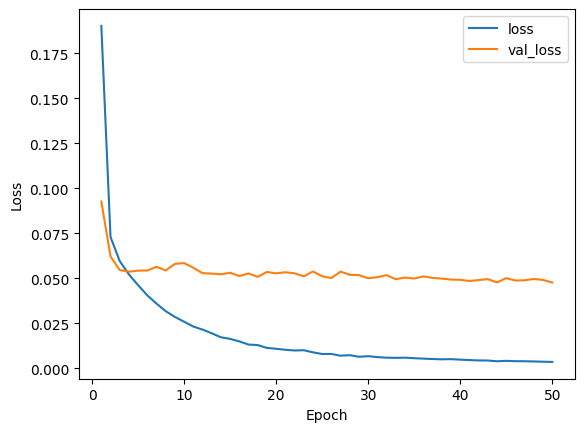

In [17]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["loss"], label="loss")
plt.plot(x, tr.history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(os.path.join(tr.log_path, "loss.png"), bbox_inches="tight")

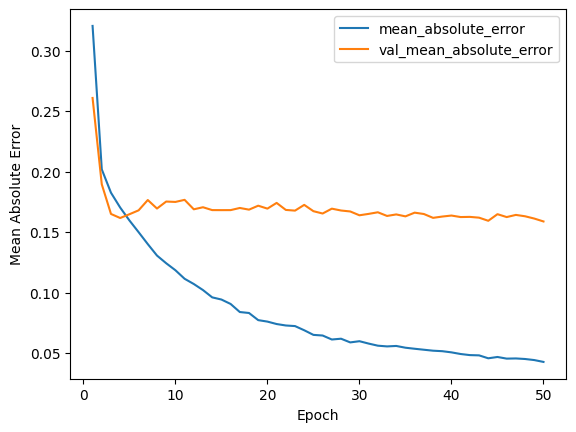

In [18]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["mean_absolute_error"], label="mean_absolute_error")
plt.plot(
    x, tr.history.history["val_mean_absolute_error"], label="val_mean_absolute_error"
)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="upper right")
plt.savefig(os.path.join(tr.log_path, "error.png"), bbox_inches="tight")

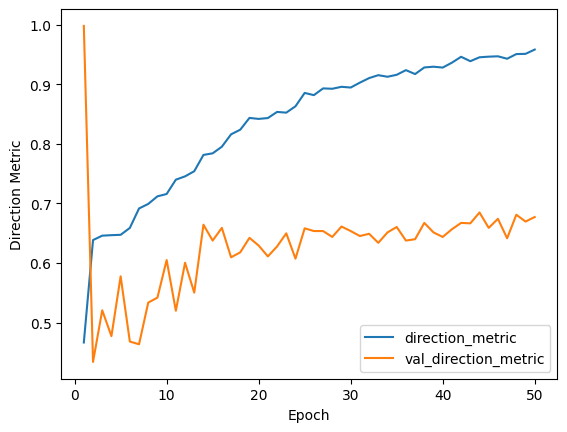

In [19]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["direction_metric"], label="direction_metric")
plt.plot(x, tr.history.history["val_direction_metric"], label="val_direction_metric")
plt.xlabel("Epoch")
plt.ylabel("Direction Metric")
plt.legend(loc="lower right")
plt.savefig(os.path.join(tr.log_path, "direction.png"), bbox_inches="tight")

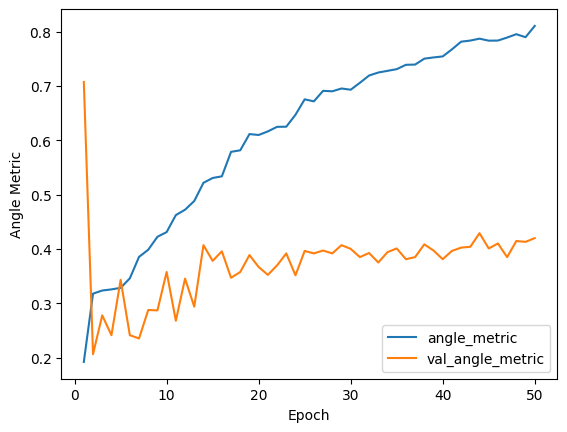

In [20]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["angle_metric"], label="angle_metric")
plt.plot(x, tr.history.history["val_angle_metric"], label="val_angle_metric")
plt.xlabel("Epoch")
plt.ylabel("Angle Metric")
plt.legend(loc="lower right")
plt.savefig(os.path.join(tr.log_path, "angle.png"), bbox_inches="tight")

### Save tf lite models for best train, best val and last checkpoint

In [21]:
best_train_checkpoint = "cp-best-train.ckpt"
best_train_tflite = utils.generate_tflite(tr.checkpoint_path, best_train_checkpoint)
utils.save_tflite(best_train_tflite, tr.checkpoint_path, "best-train")
best_train_index = np.argmin(np.array(tr.history.history["loss"]))
print(
    "Best Train Checkpoint (epoch %s) - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        best_train_index,
        tr.history.history["angle_metric"][best_train_index],
        tr.history.history["val_angle_metric"][best_train_index],
        tr.history.history["direction_metric"][best_train_index],
        tr.history.history["val_direction_metric"][best_train_index],
    )
)

Best Train Checkpoint (epoch 49) - angle: 0.8106, val_angle: 0.4202, direction: 0.9581, val_direction: 0.6771


In [22]:
best_val_checkpoint = "cp-best-val.ckpt"
best_val_tflite = utils.generate_tflite(tr.checkpoint_path, best_val_checkpoint)
utils.save_tflite(best_val_tflite, tr.checkpoint_path, "best")
utils.save_tflite(best_val_tflite, tr.checkpoint_path, "best-val")
best_val_index = np.argmin(np.array(tr.history.history["val_loss"]))
print(
    "Best Val Checkpoint (epoch %s) - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        best_val_index,
        tr.history.history["angle_metric"][best_val_index],
        tr.history.history["val_angle_metric"][best_val_index],
        tr.history.history["direction_metric"][best_val_index],
        tr.history.history["val_direction_metric"][best_val_index],
    )
)

Best Val Checkpoint (epoch 49) - angle: 0.8106, val_angle: 0.4202, direction: 0.9581, val_direction: 0.6771


In [23]:
last_checkpoint = "cp-last.ckpt"
last_tflite = utils.generate_tflite(tr.checkpoint_path, last_checkpoint)
utils.save_tflite(last_tflite, tr.checkpoint_path, "last")
print(
    "Last Checkpoint - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        tr.history.history["angle_metric"][-1],
        tr.history.history["val_angle_metric"][-1],
        tr.history.history["direction_metric"][-1],
        tr.history.history["val_direction_metric"][-1],
    )
)

Last Checkpoint - angle: 0.8106, val_angle: 0.4202, direction: 0.9581, val_direction: 0.6771


### Evaluate the best model (train loss) on the training set

In [24]:
best_train_model = utils.load_model(
    os.path.join(tr.checkpoint_path, best_train_checkpoint),
    tr.loss_fn,
    tr.metric_list,
    tr.custom_objects,
)
loss, mae, direction, angle = best_train_model.evaluate(
    tr.train_ds,
    steps=tr.image_count_train / tr.hyperparameters.TRAIN_BATCH_SIZE,
    verbose=1,
)

37/37 [==============================] - 2s 15ms/step - loss: 0.0032 - mean_absolute_error: 0.0411 - direction_metric: 0.9661 - angle_metric: 0.8405


1/1 [==============================] - 0s 145ms/step


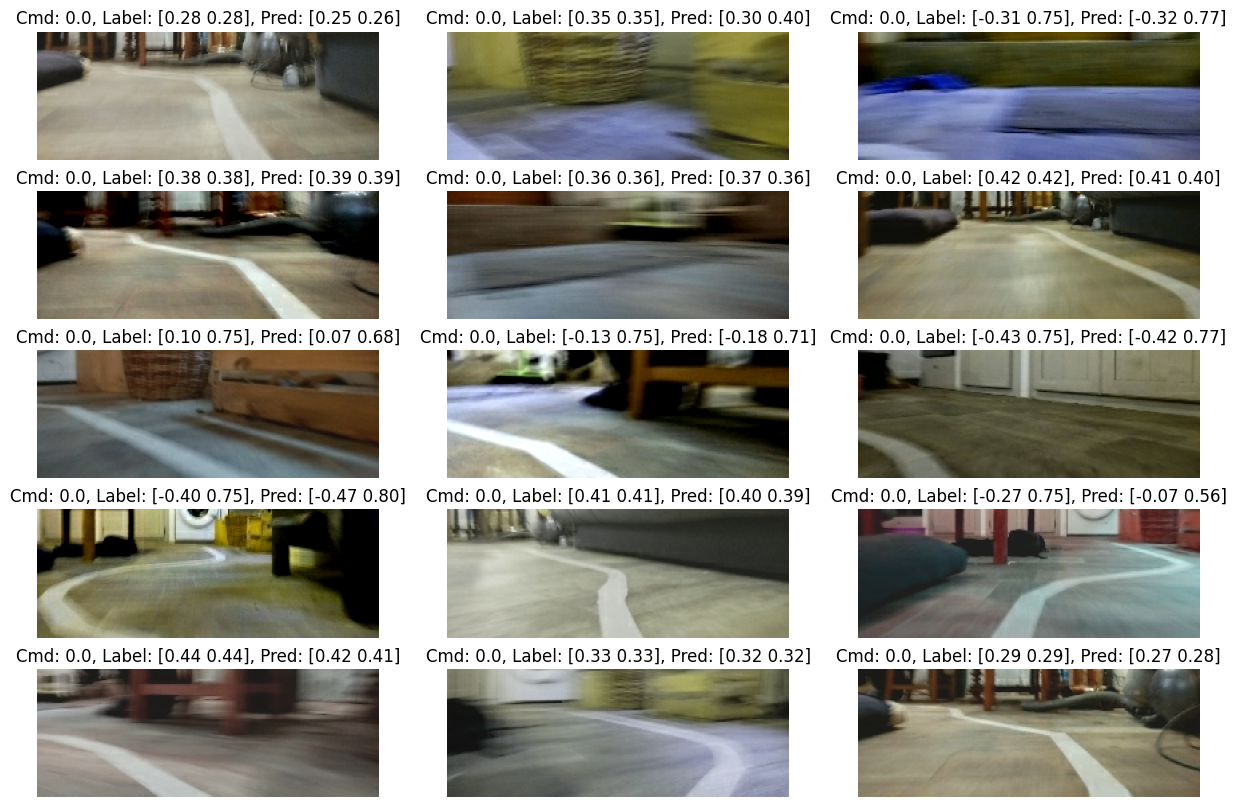

In [25]:
utils.show_batch(
    dataset=tr.train_ds, policy=tr.hyperparameters.POLICY, model=best_train_model
)

In [26]:
utils.compare_tf_tflite(best_train_model, best_train_tflite)

1/1 [==============================] - 0s 118ms/step
tflite: [[ 0.05538755 -0.10605519]]
tf: [[ 0.05815709 -0.11884908]]
Almost equal (10% tolerance): False


### Evaluate the best model (val loss) on the validation set

In [27]:
best_val_model = utils.load_model(
    os.path.join(tr.checkpoint_path, best_val_checkpoint),
    tr.loss_fn,
    tr.metric_list,
    tr.custom_objects,
)
loss, mae, direction, angle = best_val_model.evaluate(
    tr.test_ds,
    steps=tr.image_count_test / tr.hyperparameters.TEST_BATCH_SIZE,
    verbose=1,
)

82/82 [==============================] - 1s 4ms/step - loss: 0.0477 - mean_absolute_error: 0.1588 - direction_metric: 0.6771 - angle_metric: 0.4202


1/1 [==============================] - 0s 88ms/step


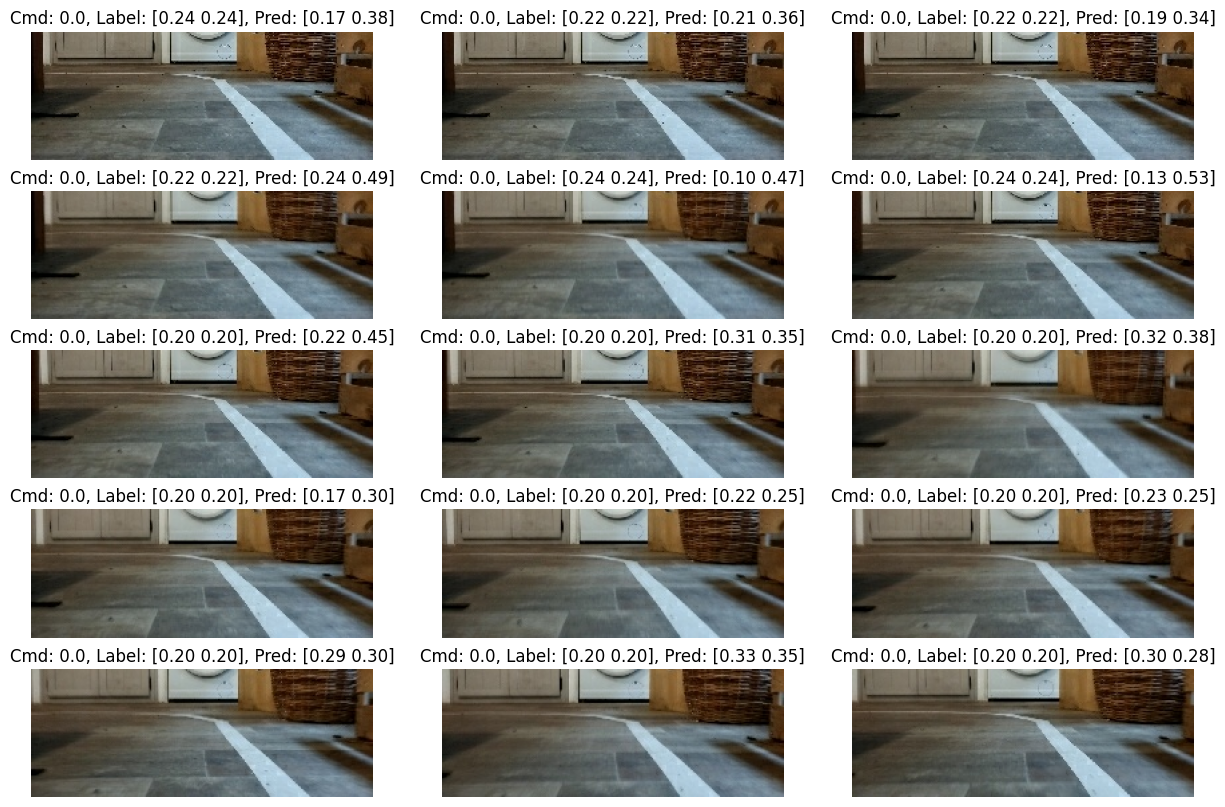

In [28]:
utils.show_batch(
    dataset=tr.test_ds, policy=tr.hyperparameters.POLICY, model=best_val_model
)

In [29]:
utils.compare_tf_tflite(best_val_model, best_val_tflite)

1/1 [==============================] - 0s 86ms/step
tflite: [[0.20189267 0.18686092]]
tf: [[0.20900632 0.19343765]]
Almost equal (10% tolerance): True


## Save the notebook as HTML

In [30]:
utils.save_notebook()
current_file = "policy_learning.ipynb"
output_file = os.path.join(tr.log_path, "notebook.html")
utils.output_HTML(current_file, output_file)

In [31]:
model_path = "models/openbot_reinforcement_lr0.0003_bz128_bn/checkpoints/best.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

ValueError: Could not open 'models/openbot_reinforcement_lr0.0003_bz128_bn/checkpoints/best.tflite'.